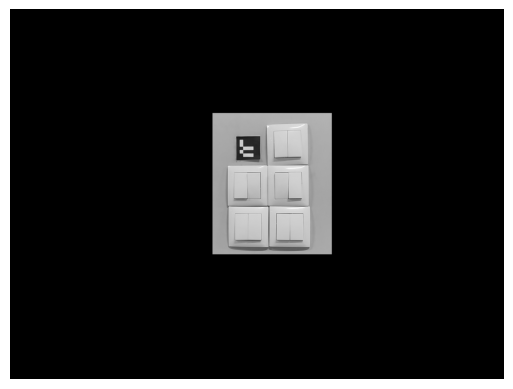

'processed_image.png'

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'mask_51.png'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axes for a cleaner display
plt.show()

# Save the processed image
output_path = 'processed_image.png'
cv2.imwrite(output_path, image)

output_path  # Return the path to the processed image


### Threshold

Shape: (3472, 4640), Type: uint8, Min: 0, Max: 255


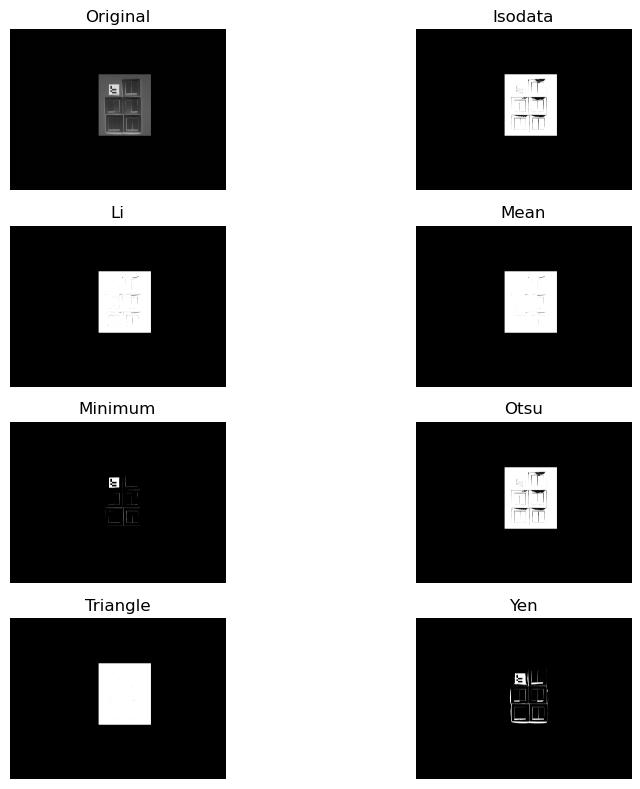

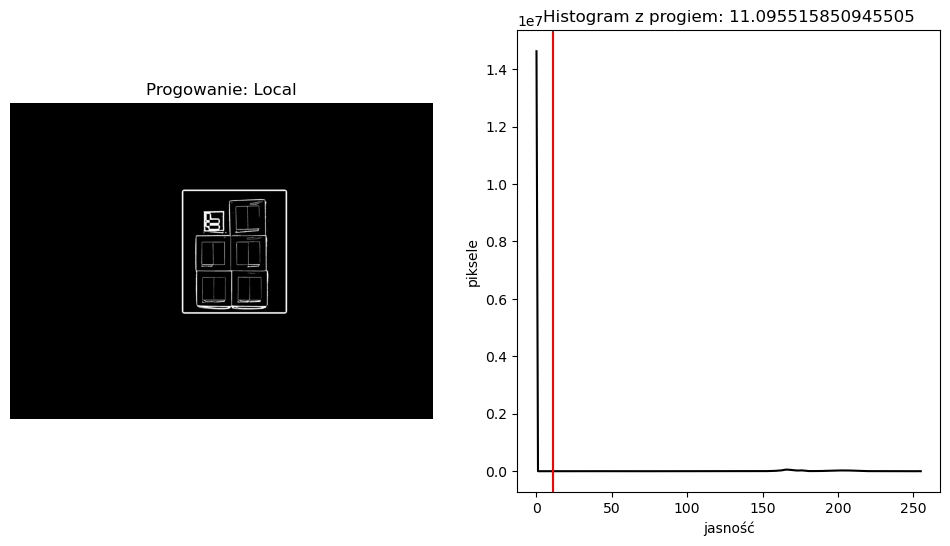

In [4]:
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local, threshold_li
from skimage import io
from skimage.filters import try_all_threshold
import numpy as np
from skimage.util import img_as_ubyte

# Funkcja do wyświetlania obrazu i histogramu
def plot_image_and_hist(image, binary_image, threshold_value, method_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Wyświetlanie obrazu binarnego
    ax[0].imshow(binary_image, cmap='gray')
    ax[0].set_title(f'Progowanie: {method_name}')
    ax[0].axis('off')

    # Obliczanie histogramu
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Wyświetlanie histogramu
    ax[1].plot(histogram, color='black')

    # If the threshold is a 2D array, compute its mean or another statistic to get a scalar
    if isinstance(threshold_value, np.ndarray):
        threshold_value = threshold_value.mean()

    ax[1].axvline(threshold_value, color='r', linestyle='-')
    ax[1].set_title(f'Histogram z progiem: {threshold_value}')
    ax[1].set_xlabel('jasność')
    ax[1].set_ylabel('piksele')
    plt.show()

# Wczytanie obrazu w odcieniach szarości
image = cv2.imread('mask_51.png', cv2.IMREAD_GRAYSCALE)
print(f"Shape: {image.shape}, Type: {image.dtype}, Min: {image.min()}, Max: {image.max()}")

# Zastosowanie try_all_threshold i wybór metod Otsu i Li
fig, ax = try_all_threshold(1-image, figsize=(10, 8), verbose=False)
plt.show()

# Progowanie metodą Otsu
thresh_local = threshold_local(image, block_size=55, offset=5)
binary_local = image > thresh_local

# Wyświetlenie wyników
plot_image_and_hist(image, 1 - binary_local, thresh_local, "Local")


### widmo górnoprzepustowe

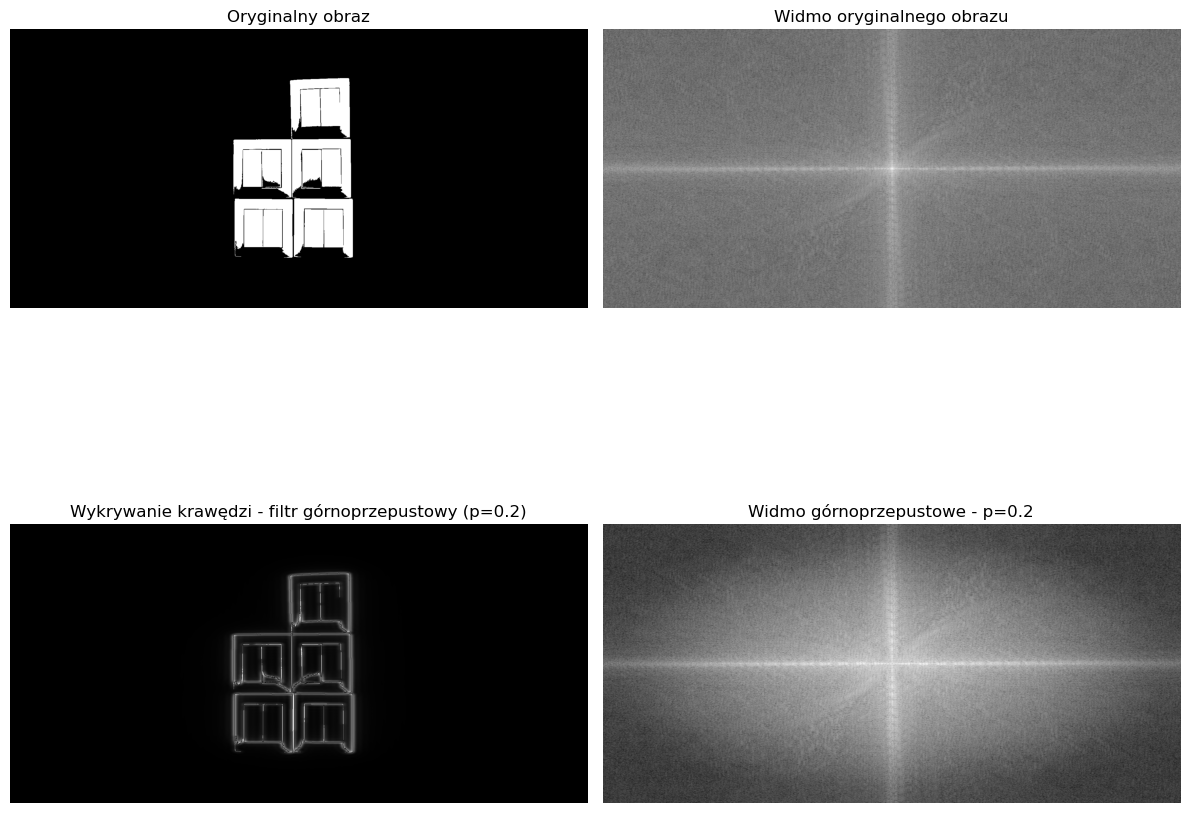

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data, filters
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import scipy.ndimage as ndi

# Wczytaj obraz
image = io.imread('filtered_51.png', as_gray=True)  # Zastąp ścieżką do obrazu

# Oblicz FFT i przesunięcie do środka dla oryginalnego obrazu
fft_image = fft2(image)
fft_image_shifted = fftshift(fft_image)
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)

# Funkcje do tworzenia masek górnoprzepustowych
def create_highpass_mask(shape, p):
    """Tworzy maskę górnoprzepustową z czarnym kołem w środku i gradientem."""
    rows, cols = shape
    mask_array = np.ones((rows, cols))
    center_row, center_col = rows // 2, cols // 2
    radius = min(rows, cols) * p / 2
    y, x = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)
    gradient_mask = np.clip(distance_from_center / radius, 0, 1)
    mask_array *= gradient_mask
    return mask_array

def apply_filter(fft_shifted, mask):
    filtered_fft = fft_shifted * mask
    filtered_image = ifft2(ifftshift(filtered_fft))
    return np.abs(filtered_image), np.log(np.abs(filtered_fft) + 1)

# Zastosowanie wygładzania obrazu
smoothed_image = ndi.gaussian_filter(image, sigma=1)

# Tworzenie maski górnoprzepustowej z większym `p` (np. 0.2)
highpass_mask = create_highpass_mask(smoothed_image.shape, 0.2)

# Zastosowanie filtru górnoprzepustowego
highpass_result, highpass_spectrum = apply_filter(fftshift(fft2(smoothed_image)), highpass_mask)

# Wizualizacja wyników
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Oryginalny obraz i jego widmo
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Oryginalny obraz')
axes[0, 0].axis('off')
axes[0, 1].imshow(magnitude_spectrum, cmap='gray')
axes[0, 1].set_title('Widmo oryginalnego obrazu')
axes[0, 1].axis('off')

# Wykrywanie krawędzi z użyciem filtru górnoprzepustowego
axes[1, 0].imshow(highpass_result, cmap='gray')
axes[1, 0].set_title('Wykrywanie krawędzi - filtr górnoprzepustowy (p=0.2)')
axes[1, 0].axis('off')
axes[1, 1].imshow(highpass_spectrum, cmap='gray')
axes[1, 1].set_title('Widmo górnoprzepustowe - p=0.2')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()



Shape: (720, 1280), Type: uint8, Min: 0, Max: 255


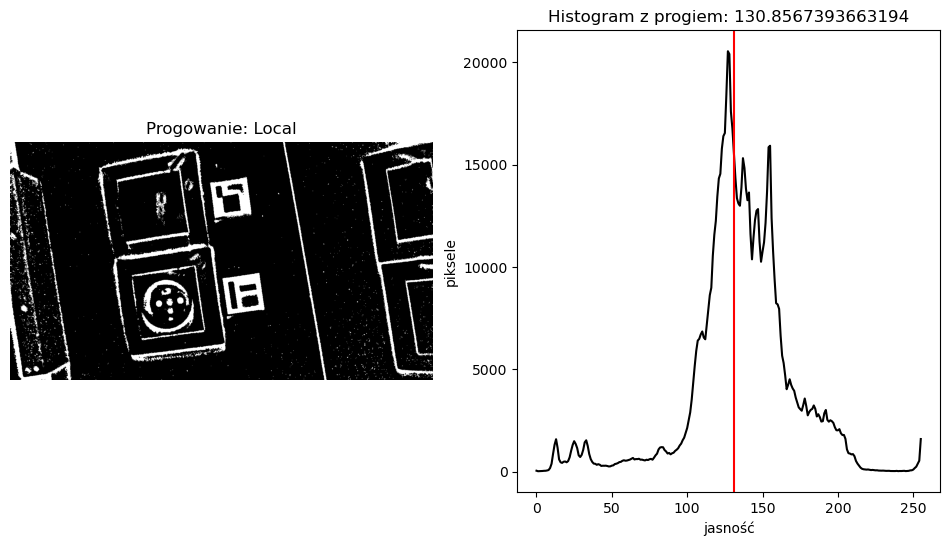

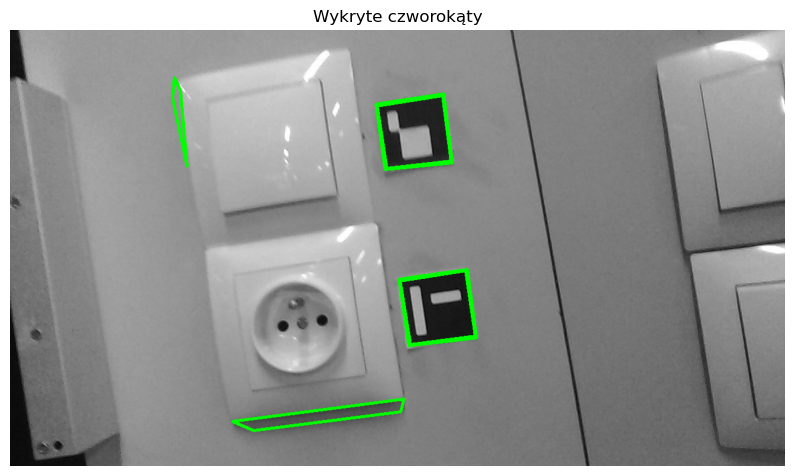

In [4]:
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import numpy as np

# Funkcja do wykrywania czworokątów
def find_quadrilaterals(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    quadrilaterals = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            # Wyszukiwanie konturów (tylko 2 wartości w OpenCV 4.x)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02 * cnt_len, True)  # Aproksymacja konturu na wielokąt
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    quadrilaterals.append(cnt)
    return quadrilaterals

# Funkcja do wyświetlania obrazu i histogramu
def plot_image_and_hist(image, binary_image, threshold_value, method_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Wyświetlanie obrazu binarnego
    ax[0].imshow(binary_image, cmap='gray')
    ax[0].set_title(f'Progowanie: {method_name}')
    ax[0].axis('off')
    
    # Obliczanie histogramu
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    # Wyświetlanie histogramu
    ax[1].plot(histogram, color='black')
    
    # Jeśli próg jest tablicą 2D, obliczamy jego średnią, aby uzyskać jedną wartość
    if isinstance(threshold_value, np.ndarray):
        threshold_value = threshold_value.mean()
    
    ax[1].axvline(threshold_value, color='r', linestyle='-')
    ax[1].set_title(f'Histogram z progiem: {threshold_value}')
    ax[1].set_xlabel('jasność')
    ax[1].set_ylabel('piksele')
    plt.show()

# Wczytanie obrazu w odcieniach szarości
image = cv2.imread('TablicaERC/WIN_20240628_15_30_52_Pro.jpg', cv2.IMREAD_GRAYSCALE)
print(f"Shape: {image.shape}, Type: {image.dtype}, Min: {image.min()}, Max: {image.max()}")

# Zastosowanie progowania lokalnego
thresh_local = threshold_local(image, block_size=55, offset=5)
binary_local = image > thresh_local

# Wyświetlenie wyników progowania
plot_image_and_hist(image, 1 - binary_local, thresh_local, "Local")

# Wykrywanie czworokątów na obrazie binarnym
quadrilaterals = find_quadrilaterals(1 - binary_local.astype(np.uint8))  # Konwertowanie na uint8
image_with_quadrilaterals = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Konwertowanie obrazu na kolorowy, aby dodać kontury
cv2.drawContours(image_with_quadrilaterals, quadrilaterals, -1, (0, 255, 0), 3)

# Wyświetlenie obrazu z wykrytymi czworokątami
plt.figure(figsize=(10, 10))
plt.imshow(image_with_quadrilaterals)
plt.title("Wykryte czworokąty")
plt.axis('off')
plt.show()
